-------------------------------------
# ECG Beat classification:
### Model - CNN

### Data Method - Patient leave-out

-------------------------------------

### Imports

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import seaborn as sns
from sklearn import *
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, LeakyReLU
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Activation
import itertools
import time
from sklearn.utils import resample
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

print("You are using Tensorflow version", tf.__version__)

print(tf.config.list_physical_devices('GPU'))

You are using Tensorflow version 2.1.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# path = './drive/MyDrive/Colab_Notebooks/ECG_with_Expected_gradients/'
path = './'

In [5]:
os.listdir(path)

['CNN_leaveout_patients_train_test.ipynb',
 'Data',
 'ECG',
 'eval_data_10k',
 'RAN_MODELS',
 'reserver_eval_data',
 'tryCNN_holdout_patients_IG_train_test.ipynb',
 'tryLSTM_leaveout_patients_EG_train_test.ipynb']

### Loading data

In [6]:
train_c1 = np.genfromtxt(path+'Data/train_patients_sc.csv', delimiter=',')
train_c0 = np.genfromtxt(path+'Data/train_patients_fc.csv', delimiter=',')
test_c1 = np.genfromtxt(path+'Data/test_patients_sc.csv', delimiter=',')
test_c0 = np.genfromtxt(path+'Data/test_patients_fc.csv', delimiter=',')

train_x_c01 = np.concatenate((train_c0[:, :-2], train_c1[:, :-2]), axis=1)
train_y_c01 = np.concatenate((train_c0[:, -2:], train_c1[:, -2:]), axis=1)

test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
test_y_c01 = np.concatenate((test_c0[:, -2:], test_c0[:, -2:]), axis=1)

train_x = train_x_c01.reshape(-1, train_x_c01.shape[1], 1).astype('float32')
test_x = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')

train_y = tf.keras.utils.to_categorical(train_y_c01[:,0])
test_y = tf.keras.utils.to_categorical(test_y_c01[:,0])

print("Train:")
print("x:", train_x.shape, "y:", train_y.shape)
print("Test")
print("x:", test_x.shape, "y:", test_y.shape)

Train:
x: (32048, 920, 1) y: (32048, 9)
Test
x: (9902, 920, 1) y: (9902, 9)


### Creating a performance metrics function

In [7]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score_macro = f1_score(test, pred, average='macro') 
    f1score_micro = f1_score(test, pred, average='micro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score macro : {}".format(f1score_macro))
    print("f1score micro : {}".format(f1score_micro))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score_macro,3), 
            round(f1score_micro, 3), cm)

### Function for building the CNN model

In [11]:
# Defining the model
verbose = 1
epochs = 10
batch_size = 50

opt = Adam(learning_rate=0.001)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        patience=2,
        min_lr=0.001 * 0.001)

def getCNNModel():
    
    input = keras.layers.Input(shape=(train_x.shape[1],train_x.shape[2]))
    x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)

    #block 2

    x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    x = keras.layers.Dropout(0.2)(x)

    #block 3
    for i in range(4):


        shortcut = MaxPooling1D(pool_size=1)(x)

        filters = 64 * ((i//2)+1)
        # print("Filter size = "+str(filters))
        x = keras.layers.Conv1D(kernel_size=16, filters=filters, strides=1, use_bias=True, padding="same", kernel_initializer='VarianceScaling')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU(alpha=0.3)(x)

        x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, padding="same", kernel_initializer='VarianceScaling')(x)

        x = keras.layers.LeakyReLU(alpha=0.3)(x)
        x = keras.layers.Dropout(0.2)(x)
    

        x = tf.keras.layers.Add()([x, shortcut])


    x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    x = keras.layers.Flatten()(x)
    out = keras.layers.Dense(9, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=[input], outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

### List of models

In [12]:
cnn1 = getCNNModel()
cnn2 = getCNNModel()
cnn3 = getCNNModel()
cnn4 = getCNNModel()
cnn5 = getCNNModel()
cnn6 = getCNNModel()
cnn7 = getCNNModel()
cnn8 = getCNNModel()
cnn9 = getCNNModel()
cnn10 = getCNNModel()

modellist = [cnn1, cnn2, cnn3, cnn4, cnn5, cnn6, cnn7, cnn8, cnn9, cnn10]

### Fitting all the models

In [13]:
modelhistory = []
for m in range(len(modellist)):
  print("*"*10,"Model",m+1,"*"*10)
  modelhistory.append(modellist[m].fit(train_x,train_y,epochs=epochs,batch_size=batch_size,validation_split=0.1,verbose=verbose, callbacks=[reduce_lr]))

********** Model 1 **********
Train on 28843 samples, validate on 3205 samples
Epoch 1/10
28843/28843 [==============================] - 26s 910us/sample - loss: 0.3156 - accuracy: 0.9249 - val_loss: 0.2241 - val_accuracy: 0.9473
Epoch 2/10
28843/28843 [==============================] - 24s 817us/sample - loss: 0.1386 - accuracy: 0.9642 - val_loss: 0.1320 - val_accuracy: 0.9710
Epoch 3/10
28843/28843 [==============================] - 24s 820us/sample - loss: 0.1060 - accuracy: 0.9719 - val_loss: 0.1606 - val_accuracy: 0.9604
Epoch 4/10
28843/28843 [==============================] - 23s 814us/sample - loss: 0.0763 - accuracy: 0.9778 - val_loss: 0.1019 - val_accuracy: 0.9813
Epoch 5/10
28843/28843 [==============================] - 24s 817us/sample - loss: 0.0678 - accuracy: 0.9804 - val_loss: 0.2065 - val_accuracy: 0.9501
Epoch 6/10
28843/28843 [==============================] - 24s 824us/sample - loss: 0.0609 - accuracy: 0.9819 - val_loss: 0.0840 - val_accuracy: 0.9828
Epoch 7/10
2884

### Model predictions

In [14]:
modelpreds = []
for m in range(len(modellist)):
  print("*"*10, "Model", m+1, "*"*10)
  modelpreds.append(np.argmax(modellist[m].predict(test_x, verbose=1),axis=1))

********** Model 1 **********
9902/9902 [==============================] - 3s 308us/sample
********** Model 2 **********
9902/9902 [==============================] - 3s 255us/sample
********** Model 3 **********
9902/9902 [==============================] - 3s 258us/sample
********** Model 4 **********
9902/9902 [==============================] - 3s 257us/sample
********** Model 5 **********
9902/9902 [==============================] - 3s 254us/sample
********** Model 6 **********
9902/9902 [==============================] - 3s 255us/sample
********** Model 7 **********
9902/9902 [==============================] - 3s 254us/sample
********** Model 8 **********
9902/9902 [==============================] - 3s 255us/sample
********** Model 9 **********
9902/9902 [==============================] - 3s 257us/sample
********** Model 10 **********
9902/9902 [==============================] - 3s 253us/sample


### Generating the metrics

In [15]:
results = []
cnn_actual_value=np.argmax(test_y,axis=1)
for p in range(len(modelpreds)):
  print("*"*10,"Model",p+1,"*"*10)
  results.append(showResults(cnn_actual_value, modelpreds[p],'CNN'+str(p)))

********** Model 1 **********
Accuracy  : 0.7532821652191476
Precision : 0.4074223462638685
Recall : 0.42022256210830744
f1score macro : 0.38129544898385725
f1score micro : 0.7532821652191477
********** Model 2 **********
Accuracy  : 0.7997374267824682
Precision : 0.4099871818110006
Recall : 0.4650840780406695
f1score macro : 0.42180132476823046
f1score micro : 0.7997374267824682
********** Model 3 **********
Accuracy  : 0.8105433245808927
Precision : 0.41831518826796943
Recall : 0.46586113203712703
f1score macro : 0.42209148972206295
f1score micro : 0.8105433245808927
********** Model 4 **********
Accuracy  : 0.8276105837204605
Precision : 0.4127622507039629
Recall : 0.4840393347578885
f1score macro : 0.43379302839757183
f1score micro : 0.8276105837204605
********** Model 5 **********
Accuracy  : 0.8267016764290043
Precision : 0.41494906651954994
Recall : 0.48602243525127425
f1score macro : 0.4399645766106275
f1score micro : 0.8267016764290043
********** Model 6 **********

C:\Users\podda\anaconda3\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy  : 0.8184205211068472
Precision : 0.41204995039912534
Recall : 0.4722300907776241
f1score macro : 0.4279976223564739
f1score micro : 0.8184205211068472
********** Model 7 **********
Accuracy  : 0.8189254696021006
Precision : 0.41019521510204937
Recall : 0.4725669874167345
f1score macro : 0.42696444344538
f1score micro : 0.8189254696021006
********** Model 8 **********
Accuracy  : 0.8108462936780448
Precision : 0.41511005250260613
Recall : 0.4657831912338075
f1score macro : 0.4221113207520988
f1score micro : 0.8108462936780448
********** Model 9 **********
Accuracy  : 0.820137345990709
Precision : 0.42810061443624314
Recall : 0.4735707404102315
f1score macro : 0.4309448697077092
f1score micro : 0.820137345990709
********** Model 10 **********
Accuracy  : 0.8215512017774187
Precision : 0.41044167102297896
Recall : 0.47850857365835464
f1score macro : 0.43285223973620035
f1score micro : 0.8215512017774187


### Generating the confusion matrices

In [16]:
cms = []
for p in modelpreds:
  cms.append(confusion_matrix(cnn_actual_value, p, normalize='true'))

### Extracting model train and validation accuracy & loss

In [17]:
modelosses = []
modeleval_losses = []
modelacc = []
modeleval_acc = []
for h in modelhistory:
  modelosses.append(h.history['loss'])
  modeleval_losses.append(h.history['val_loss'])
  modelacc.append(h.history['accuracy'])
  modeleval_acc.append(h.history['val_accuracy'])
modelosses = np.array(modelosses)
modeleval_losses = np.array(modeleval_losses)
modelacc = np.array(modelacc)
modeleval_acc = np.array(modeleval_acc)
# losses , eval_losses, accuracy, eval_accuracy
history = np.array([modelosses, modeleval_losses, modelacc, modeleval_acc])

### Saving the data

In [18]:
# Saving data LSTM patient leavout
new_path = path+"eval_data_10k/cnn_pl/"

modelpreds = np.array(modelpreds)
results = np.array(results)
cms = np.array(cms)
# modelhistory = np.array(modelhistory)
np.save(new_path+"cnn_modelpreds.npy", modelpreds)
np.save(new_path+"cnn_results.npy", results)
np.save(new_path+"cnn_cms.npy", cms)
np.save(new_path+"cnn_history.npy", history )


C:\Users\podda\anaconda3\envs\ecg\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


Visualising the Mean Confusion Matrix

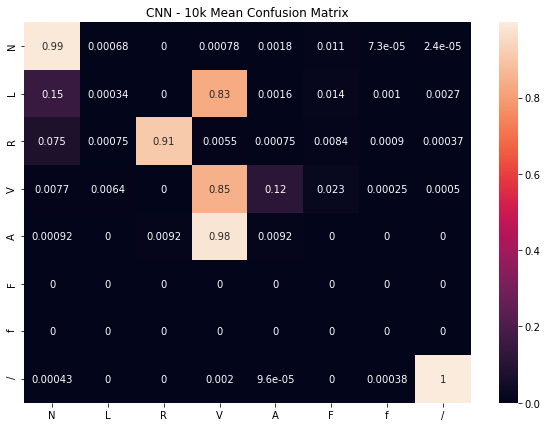

In [19]:
categories=['N','L','R','V','A','F','f','/']
cm = np.mean(cms, axis=0)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)
plt.title('CNN - 10k Mean Confusion Matrix')
# plt.savefig("lstm_mean_cm_pl.png", dpi=300)
plt.show()

### Mean Metrics

In [20]:
metrics = ["Accuracy", "Precision", "Recall", "f1-score macro", "f1-score micro"]
mean_metrics = np.mean(results[:,1:6], axis=0)
for i in range(len(mean_metrics)):
  print(metrics[i],":",mean_metrics[i])

Accuracy : 0.8109
Precision : 0.4138
Recall : 0.46849999999999997
f1-score macro : 0.42400000000000004
f1-score micro : 0.8109


### Mesn CNN Loss vs Accuracy Plot

In [21]:
modelosses = []
modeleval_losses = []
modelacc = []
modeleval_acc = []
for h in modelhistory:
  modelosses.append(h.history['loss'])
  modeleval_losses.append(h.history['val_loss'])
  modelacc.append(h.history['accuracy'])
  modeleval_acc.append(h.history['val_accuracy'])
modelosses = np.array(modelosses)
modeleval_losses = np.array(modeleval_losses)
modelacc = np.array(modelacc)
modeleval_acc = np.array(modeleval_acc)

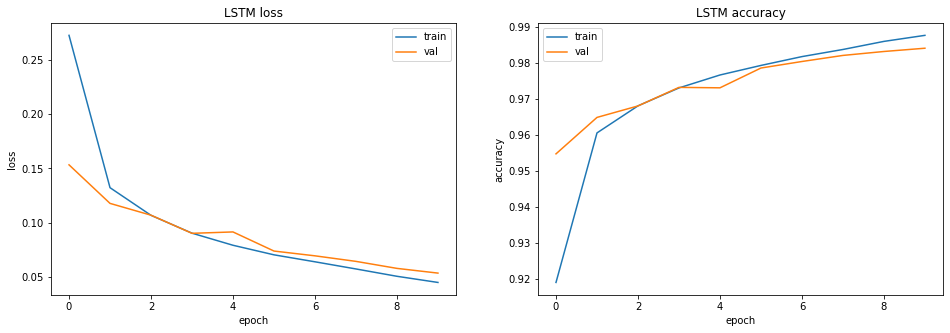

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax[0].plot(np.mean(modelosses, axis=0))
ax[0].plot(np.mean(modeleval_losses, axis=0))
ax[0].set_title('LSTM loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper right')
ax[1].plot(np.mean(modelacc,axis=0))
ax[1].plot(np.mean(modeleval_acc, axis=0))
ax[1].set_title('LSTM accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.show()
# fig.savefig('lstm_leaveout_patients_loss_and_accuracy.jpg')